In [1]:
from photo_utils import *
import os

: 

# Convert segmentation maps to grayscale labels

In [2]:
preds_folder = 'R:/nc_state/research/gym_datasets/CB_03_12172023/pred_segs'
labels_destination = 'R:/nc_state/research/gym_datasets/CB_03_12172023/labels'

In [3]:
create_labels_from_preds(preds_folder, labels_destination, color_map=None)

Generating labels from predictions: 100%|██████████| 106/106 [00:12<00:00,  8.44it/s]


# Plot segmentation overlays

In [4]:
from functions import *

In [5]:
images_folder = 'R:/nc_state/research/gym_datasets/CB_03_12172023/orig_images'
overlay_destination = 'R:/nc_state/research/gym_datasets/CB_03_12172023'

In [6]:
gen_segmap_overlays(images_folder, preds_folder, overlay_destination)

Generating segmentation overlays...: 100%|██████████| 106/106 [03:05<00:00,  1.75s/it]

Folder of segmentation overlays generated.


# Rectify Predicted Labels

## Import dependencies

In [10]:
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from rectification_utils import *

import open3d as o3d
import laspy
import lazrs
import laszip

: 

## Set calibration values

In [11]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])

: 

In [12]:
extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

## Generate grid

In [21]:
file_path = r"R:\nc_state\research\depth_mapping\lidar\lidar_data\Job1051007_34077_04_88.laz"

las = laspy.read(file_path)

In [22]:
pts_mask = las.classification == 2 # land classification (1 is unclassified points)

xyz_t = np.vstack([las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]])

building_xyz_m = xyz_t * 0.3048 

In [23]:
point_cloud_df = pd.DataFrame(building_xyz_m.T, columns=['x', 'y', 'z'])

max_x_extent = 712230
min_x_extent = 712160
max_y_extent = 33170
min_y_extent = 33100

# Filter the DataFrame
filtered_df = point_cloud_df[
    (point_cloud_df['x'] >= min_x_extent) & (point_cloud_df['x'] <= max_x_extent) &
    (point_cloud_df['y'] >= min_y_extent) & (point_cloud_df['y'] <= max_y_extent)
]

x = filtered_df['x'].values
y = filtered_df['y'].values
z = filtered_df['z'].values

resolution = 0.01 # meters

In [24]:
pts_array = np.array([x, y, z])

print(pts_array.shape)

(3, 35549)


In [26]:
grid_x, grid_y, grid_z = gen_grid(min_x_extent, max_x_extent, min_y_extent, max_y_extent, resolution, pts_array)

Directory to store grids already exists: generated_grids


In [27]:
grid_x = grid_x.T
grid_y = grid_y.T
grid_z = grid_z.T

In [28]:
# Get the topo colormap from cmocean
cmap = cmocean.cm.topo

# Truncate the colormap to get only the above-land portion
# Assuming "above land" is the upper half of the colormap
above_land_cmap = LinearSegmentedColormap.from_list(
    'above_land_cmap', cmap(np.linspace(0.5, 1, 256))
)

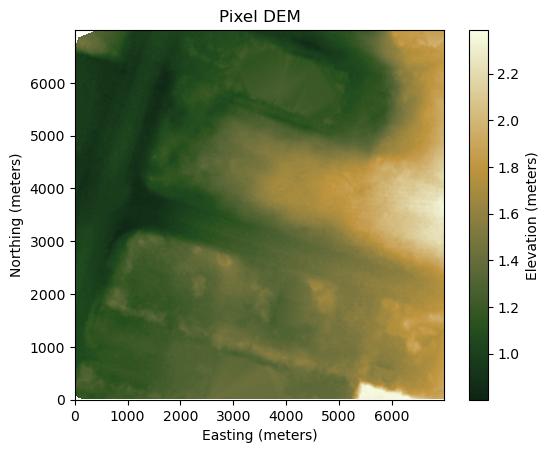

In [29]:
plt.imshow(grid_z, origin='lower', cmap=above_land_cmap)
plt.colorbar(label='Elevation (meters)')
plt.title('Pixel DEM')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

# Save the figure before showing it
# plt.savefig('pixel_DEM_1cm_res_CB_03.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

## Rectify Labels and Images

In [30]:
results = mergeRectifyFolder(images_folder, intrinsics, extrinsics, grid_x, grid_y, grid_z)

r:\nc_state\research\depth_mapping\rectification_utils.py:257: RuntimeWarning: invalid value encountered in cast
  Ud = np.round(Ud).astype(int)
r:\nc_state\research\depth_mapping\rectification_utils.py:258: RuntimeWarning: invalid value encountered in cast
  Vd = np.round(Vd).astype(int)
r:\nc_state\research\depth_mapping\rectification_utils.py:268: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


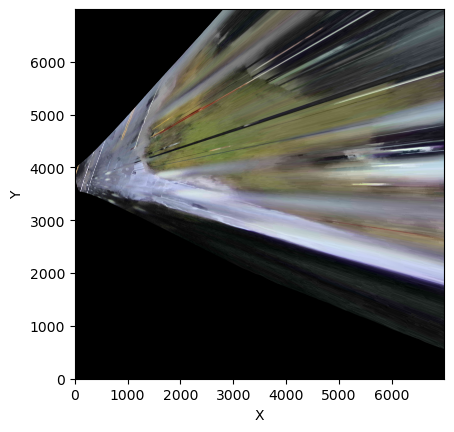

In [31]:
plt.imshow(results.iloc[1]['ir'])
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [32]:
zarr_store_path = overlay_destination
save_df_to_zarr(results, zarr_store_path)

<zarr.hierarchy.Group '/'>

In [33]:
labels = mergeRectifyLabelsFolder(labels_destination, intrinsics, extrinsics, grid_x, grid_y, grid_z)
save_df_to_zarr(labels, zarr_store_path)

r:\nc_state\research\depth_mapping\rectification_utils.py:283: RuntimeWarning: invalid value encountered in cast
  Ud = np.round(Ud).astype(int)
r:\nc_state\research\depth_mapping\rectification_utils.py:284: RuntimeWarning: invalid value encountered in cast
  Vd = np.round(Vd).astype(int)
r:\nc_state\research\depth_mapping\rectification_utils.py:293: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


<zarr.hierarchy.Group '/'>

In [35]:
labels.keys()

Index(['image_name', 'ir'], dtype='object')

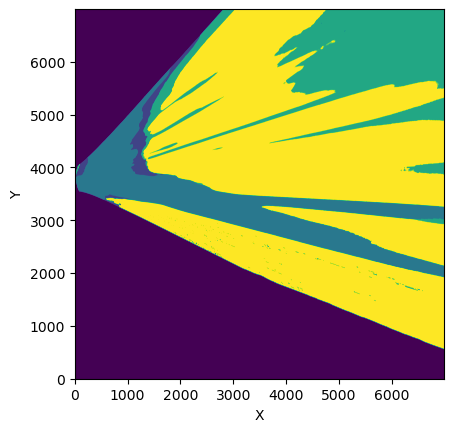

In [36]:
plt.imshow(labels.iloc[1]['ir'])
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

# Depth Mapping

In [42]:
from scipy.ndimage import label
import matplotlib.colors as mcolors
from scipy.ndimage import binary_closing
from skimage.measure import find_contours
from scipy.spatial import cKDTree

In [49]:
image_store_path = r"R:\nc_state\research\depth_mapping\rectifications\CB_10_02_2023\rect_arrays.zarr"

# Open the Zarr store in read mode
store = zarr.open_group(image_store_path, mode='r')

# Load the specific array using its name
background = store['CAM_CB_03_20231002150626_rectified'][:]
grayscale_image = np.dot(background[...,:3], [0.2989, 0.5870, 0.1140])

In [50]:
zarr_store_path = r"R:\nc_state\research\gym_datasets\CB_03_12172023\label_rectifications"

In [55]:
# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

depth_data = []

# Iterate over all the keys (arrays) in the Zarr store
for array_name in store.keys():
    if array_name.endswith('predseg_labels_rectified'):
        print(f"Processing array: {array_name}")
    
        # Load the array using its name
        ir_array = store[array_name][:]

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries

        masked_labels = np.where(ir_array == 1, ir_array, 0)
        masked_labels = np.squeeze(masked_labels)

        closed_data = binary_closing(masked_labels, structure=np.ones((3, 3)))
    
        labeled_data, num_features = label(closed_data)

        min_size = 500  # Minimum size of a pond
        unique, counts = np.unique(labeled_data, return_counts=True)
        small_ponds = unique[counts < min_size]  # Identify small ponds
        labeled_data[np.isin(labeled_data, small_ponds)] = 0  # Remove small ponds

        # Reapply the label function to relabel the remaining ponds
        labeled_data, num_features = label(labeled_data)

        # Count the number of unique non-zero features (ponds)
        num_features = np.max(labeled_data)  # The highest label after relabeling is the number of features

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, 0)  # Use np.nan or another value for masked entries


        # Sample array with labeled ponds (this should be your `labeled_data`)
        arr = masked_elevations  # Replace with your masked elevation data
        labeled_data = labeled_data  # The output from your previous labeling process

        # Step 2: Get the unique pond labels (excluding background)
        unique_ponds = np.unique(labeled_data)
        unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label

        # Initialize a dictionary to hold contours for each pond
        pond_contours = {}

        # Step 3: For each pond, extract contours separately
        for pond_id in unique_ponds:
            # Create a binary mask for the current pond
            pond_mask = (labeled_data == pond_id)

            # Replace NaNs with zeros for contour detection
            pond_arr = np.where(pond_mask, arr, 0)

            # Find contours for the pond
            contours = find_contours(pond_arr, level=0.5)
    
            # Store the contours for this pond in the dictionary
            pond_contours[pond_id] = contours

        # Step 4: Convert contour coordinates to integer indices and extract values for each pond
        contour_pixels_per_pond = {}
        contour_values_per_pond = {}

        for pond_id, contours in pond_contours.items():
            contour_pixels = []
            contour_values = []
    
            for contour in contours:
                for point in contour:
                    y, x = np.round(point).astype(int)
                    if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:  # Ensure indices are within bounds
                        contour_pixels.append((x, y))
                        contour_values.append(arr[y, x])
    
            # Store contour pixels and values for this pond
            contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
            contour_values_per_pond[pond_id] = np.array(contour_values)

        # Initialize a dictionary to hold contours for each pond
        pond_depths = {}

        # Step 3: For each pond, extract contours separately
        for pond_id in unique_ponds:
            # Create a binary mask for the current pond
            pond_mask = (labeled_data == pond_id)
            # pond_squeezed = pond_mask.squeeze()
            # mask = (labels_squeezed == pond_id)
            masked_elevations = np.where(pond_mask, grid_z, np.nan)

            max_elevation = np.nanmedian(contour_values_per_pond[pond_id])

            depth_map = masked_elevations - max_elevation
            depth_map[depth_map > 0] = 0
            depth_map = np.abs(depth_map)

            # Store the contours for this pond in the dictionary
            pond_depths[pond_id] = depth_map

        combined_depth_map = pond_depths[1]

        # Loop over the remaining arrays, starting from key 2
        for i in range(2, len(pond_depths) + 1):
            combined_depth_map = np.where(np.isnan(combined_depth_map), pond_depths[i], np.where(np.isnan(pond_depths[i]), combined_depth_map, combined_depth_map + pond_depths[i]))

        # Plot the image
        plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

        # Overlay the depth map
        im = plt.imshow(combined_depth_map, cmap=cmocean.cm.deep, vmin=0, vmax=0.5)  # Adjust alpha for transparency


        # Add a colorbar for the depth map
        cbar = plt.colorbar(im, label='Depth')
        cbar.set_label('Depth (meters)')

        plt.gca().invert_yaxis()
        plt.xlabel('X (cm)')
        plt.ylabel('Y (cm)')

        # Save the figure
        plt.savefig(f'R:/nc_state/research/gym_datasets/CB_03_12172023/ponding_method_depth_maps/{array_name}.png')

        plt.close()

        depth_data.append({'image_name': array_name + '_depth_map_median_edge_ponding', 'depth_map': combined_depth_map})

results = pd.DataFrame(depth_data)
        

Processing array: CAM_CB_03_20231217123025_predseg_labels_rectified
Processing array: CAM_CB_03_20231217123625_predseg_labels_rectified
Processing array: CAM_CB_03_20231217124225_predseg_labels_rectified
Processing array: CAM_CB_03_20231217124825_predseg_labels_rectified
Processing array: CAM_CB_03_20231217125425_predseg_labels_rectified
Processing array: CAM_CB_03_20231217130025_predseg_labels_rectified
Processing array: CAM_CB_03_20231217130625_predseg_labels_rectified
Processing array: CAM_CB_03_20231217131225_predseg_labels_rectified
Processing array: CAM_CB_03_20231217131825_predseg_labels_rectified
Processing array: CAM_CB_03_20231217132425_predseg_labels_rectified
Processing array: CAM_CB_03_20231217133025_predseg_labels_rectified
Processing array: CAM_CB_03_20231217133626_predseg_labels_rectified
Processing array: CAM_CB_03_20231217134225_predseg_labels_rectified
Processing array: CAM_CB_03_20231217134825_predseg_labels_rectified
Processing array: CAM_CB_03_20231217135426_preds

MemoryError: Unable to allocate 374. MiB for an array with shape (7000, 7000) and data type float64

In [ ]:
len(depth_data)

: 